# Assignment 1
### This notebook implements testing of the results on the holdout set of data for five
### models with the two datasets.
These two datasets look at Diabetes health predictors and Airline Passenger Satisfaction.
The files that we used are prepared by the Assignment1-DataAnalysis.ipynb notebook. 

Here we take the trained models from the Assignment1-Training.ipynb notebook and 

### Airline Passenger 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,PrecisionRecallDisplay
import seaborn as sn
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from sklearn.exceptions import ConvergenceWarning
import warnings
import pickle
import graphviz
from sklearn import tree

In [2]:
plt.rcParams['lines.linewidth'] = 5
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=18) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels

In [3]:
## Code to plot ROC/DET curves

In [4]:
def plot_roc_det_curves(classifiers,X_test,y_test,image_name):
    fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(20, 10),linewidth=10)

    for clf in classifiers:

        RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=clf.__class__.__name__)
        DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=clf.__class__.__name__)

    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_det.set_title("Detection Error Tradeoff (DET) curves")

    ax_roc.grid(linestyle="--")
    ax_det.grid(linestyle="--")

    plt.legend()
    fig.tight_layout()
    fig.show()
    plt.savefig(image_name)
    plt.show()

## Code to plot precision/recall curves

In [5]:
def plot_precision_recall_curves(classifiers,X_test,y_test):
    fig, ax = plt.subplots(1, 1, figsize=(11, 5),linewidth=10)

    for clf in classifiers:
        display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=clf.__class__.__name__, linewidth=10)
        RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=clf.__class__.__name__, linewidth=10)
        DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=clf.__class__.__name__, linewidth=10)

    ax.set_title("Precision/Recall Curves")

    ax.grid(linestyle="--")
    ax_det.grid(linestyle="--")

    plt.legend()
    plt.show()

# display = PrecisionRecallDisplay.from_estimator(
#     classifier, X_test, y_test, name="LinearSVC"
# )
# _ = display.ax_.set_title("2-class Precision-Recall curve")


### Code to plot confusion matrices

In [6]:
def plot_confusion_matrices(classifiers,X,y):
    for name,clf in classifiers.items():
        y_pred = clf.predict(X)
        cm = confusion_matrix(y, y_pred,labels=clf.classes_)

        cm_display = ConfusionMatrixDisplay(cm,display_labels=clf.classes_).plot()
        cm_display.ax_.set_title(f'{name} - Accuracy: {accuracy_score(y, y_pred):.3f} - Precision: {precision_score(y, y_pred):.3f} - Recall: {recall_score(y, y_pred):.3f} F1- {f1_score(y, y_pred):.3f} ')
        display = PrecisionRecallDisplay.from_estimator(clf, X, y, name=name)
        _ = display.ax_.set_title(f'Precision-Recall curve for {name}')
        # print(f'Precision for {name}: {precision_score(y, y_pred):.3f}')
        # print(f'Recall for {name}: {recall_score(y, y_pred):.3f}')
        # print(f'F1 for {name}: {f1_score(y, y_pred):.3f}')
    plt.show()

In [7]:
font = {'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)

In [8]:
airline_data = pd.read_csv('./airline_data_test.csv',index_col=0)
airline_data = pd.read_csv('./airline_data_test_business.csv',index_col=0)

In [9]:
airline_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17980 entries, 0 to 25974
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             17980 non-null  float64
 1   Customer Type                      17980 non-null  float64
 2   Age                                17980 non-null  float64
 3   Type of Travel                     17980 non-null  float64
 4   Class                              17980 non-null  float64
 5   Flight Distance                    17980 non-null  float64
 6   Inflight wifi service              17980 non-null  float64
 7   Departure/Arrival time convenient  17980 non-null  float64
 8   Ease of Online booking             17980 non-null  float64
 9   Gate location                      17980 non-null  float64
 10  Food and drink                     17980 non-null  float64
 11  Online boarding                    17980 non-null  flo

In [10]:
airline_data.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0.0,1.0,0.576923,1.0,0.0,0.026050,1.0,0.8,0.6,0.75,...,1.0,1.0,1.0,1.00,0.25,1.0,1.0,0.044326,0.039462,1.0
1,0.0,1.0,0.371795,1.0,1.0,0.571890,0.2,0.2,0.6,0.00,...,0.8,0.8,0.8,0.75,0.50,0.8,1.0,0.000000,0.000000,1.0
2,1.0,0.0,0.166667,1.0,0.0,0.032512,0.4,0.0,0.4,0.75,...,0.4,0.8,0.2,0.50,0.25,0.4,0.4,0.000000,0.000000,0.0
3,1.0,1.0,0.474359,1.0,1.0,0.675687,0.0,0.0,0.0,0.25,...,0.2,0.2,0.2,0.00,0.50,0.2,0.8,0.000000,0.005381,1.0
4,0.0,1.0,0.538462,1.0,0.0,0.232431,0.4,0.6,0.8,0.50,...,0.4,0.4,0.4,0.25,0.75,0.4,0.8,0.000000,0.017937,1.0


In [11]:
X_airline = airline_data
y_airline = X_airline['satisfaction']
X_airline = X_airline[['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
                       'Flight Distance', 'Inflight wifi service',
                       'Departure/Arrival time convenient', 'Ease of Online booking',
                       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
                       'Inflight entertainment', 'On-board service', 'Leg room service',
                       'Baggage handling', 'Checkin service', 'Inflight service',
                       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']]


In [12]:
y_airline

0        1.0
1        1.0
2        0.0
3        1.0
4        1.0
        ... 
25969    1.0
25970    0.0
25971    0.0
25972    1.0
25974    1.0
Name: satisfaction, Length: 17980, dtype: float64

# Read airline models and run tests to score

In [13]:
# Airline models

In [14]:
with open('best_search_decision_airline.pkl', 'rb') as f:
    best_search_decision_airline = pickle.load(f)
with open('best_search_boosted_airline.pkl', 'rb') as f:
    best_search_boosted_airline = pickle.load(f)
with open('best_search_knn_airline.pkl', 'rb') as f:
    best_search_knn_airline = pickle.load(f)
with open('best_search_svm_airline.pkl', 'rb') as f:
    best_search_svm_airline = pickle.load(f)
with open('best_search_nn_airline.pkl', 'rb') as f:
    best_search_nn_airline = pickle.load(f)

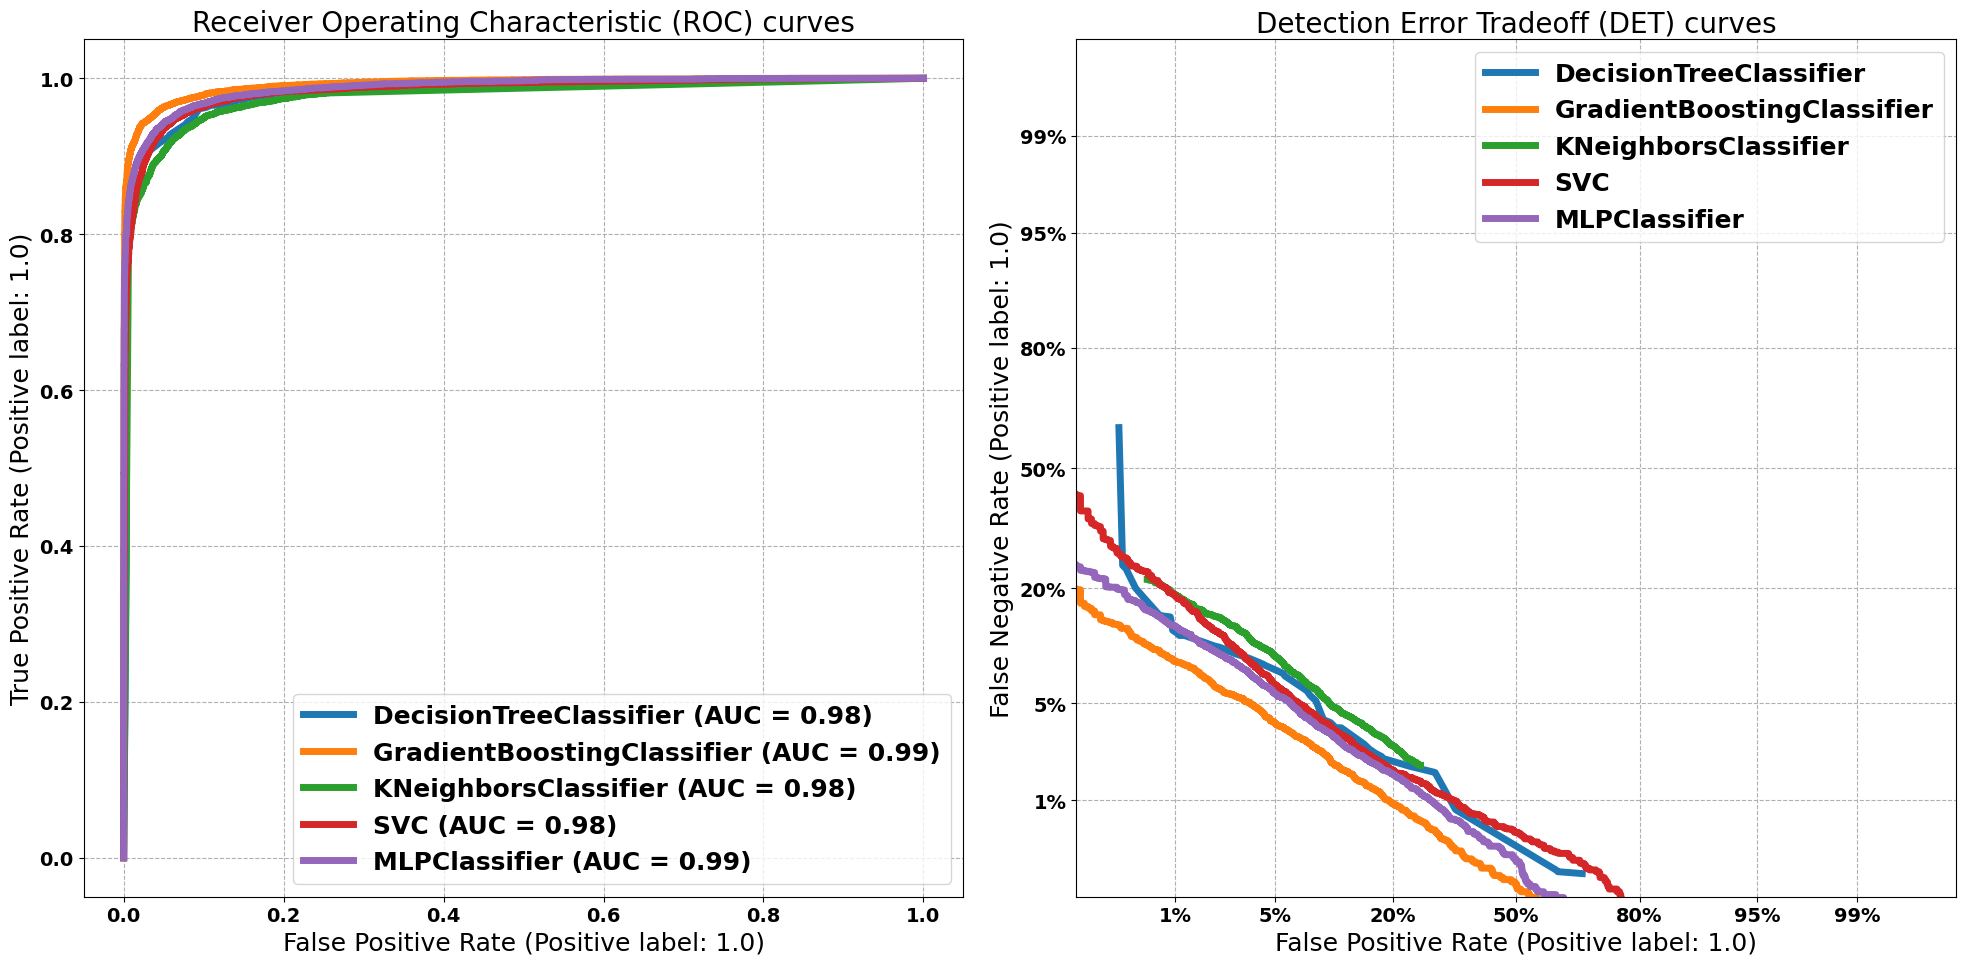

In [15]:
plot_roc_det_curves([best_search_decision_airline, best_search_boosted_airline, best_search_knn_airline,best_search_svm_airline,best_search_nn_airline],
                    X_airline,y_airline,'airline_test_result_roc_det_curve.png')


In [16]:
classifiers_airline = {
    'Airline Data - Decision Tree Model': best_search_decision_airline, 
    'Airline Data - Boosted Decision Tree Model': best_search_boosted_airline, 
    'Airline Data - K-Neares Neigbor Model': best_search_knn_airline,
    'Airline Data - Support Vector Model': best_search_svm_airline,
    'Airline Data - Neural Network Model': best_search_nn_airline
}

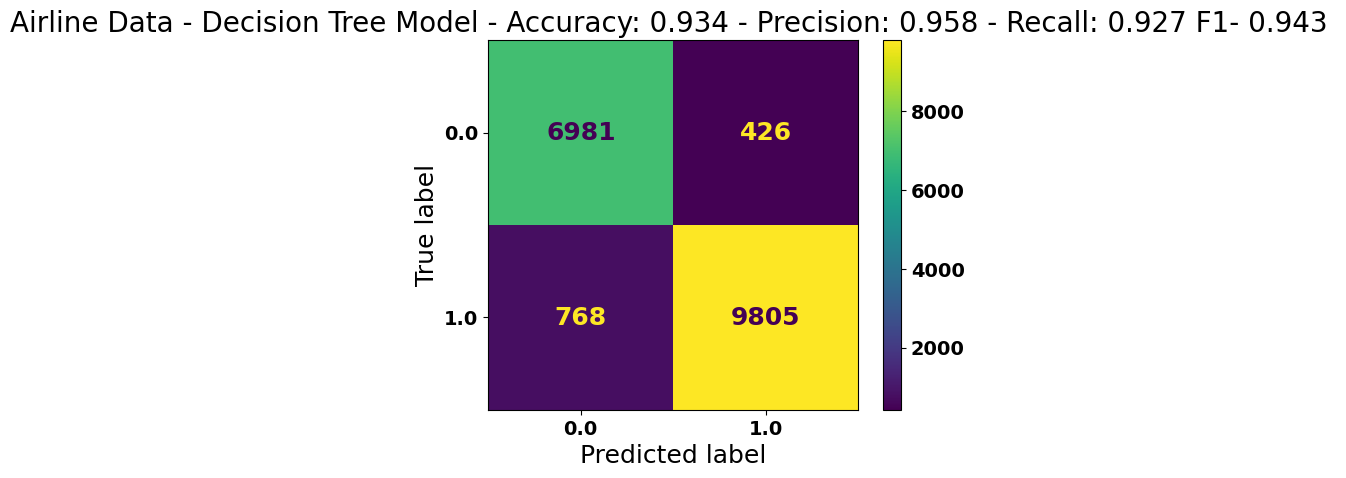

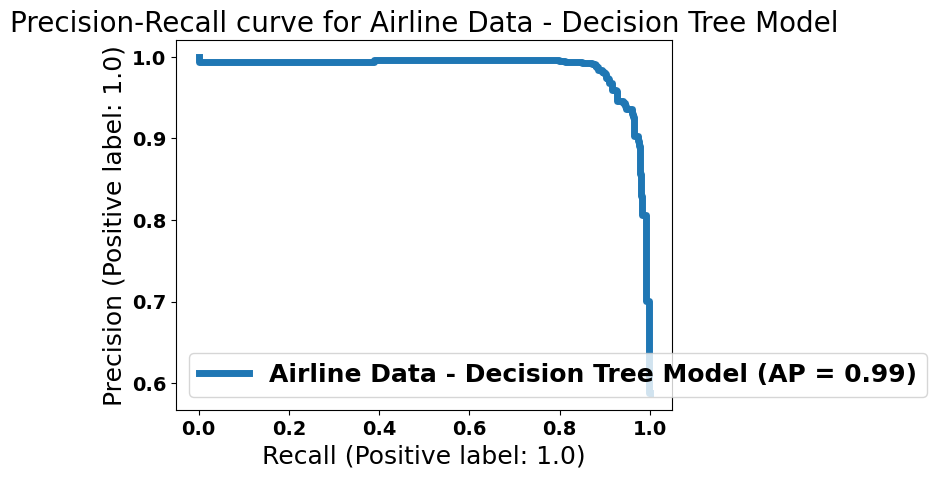

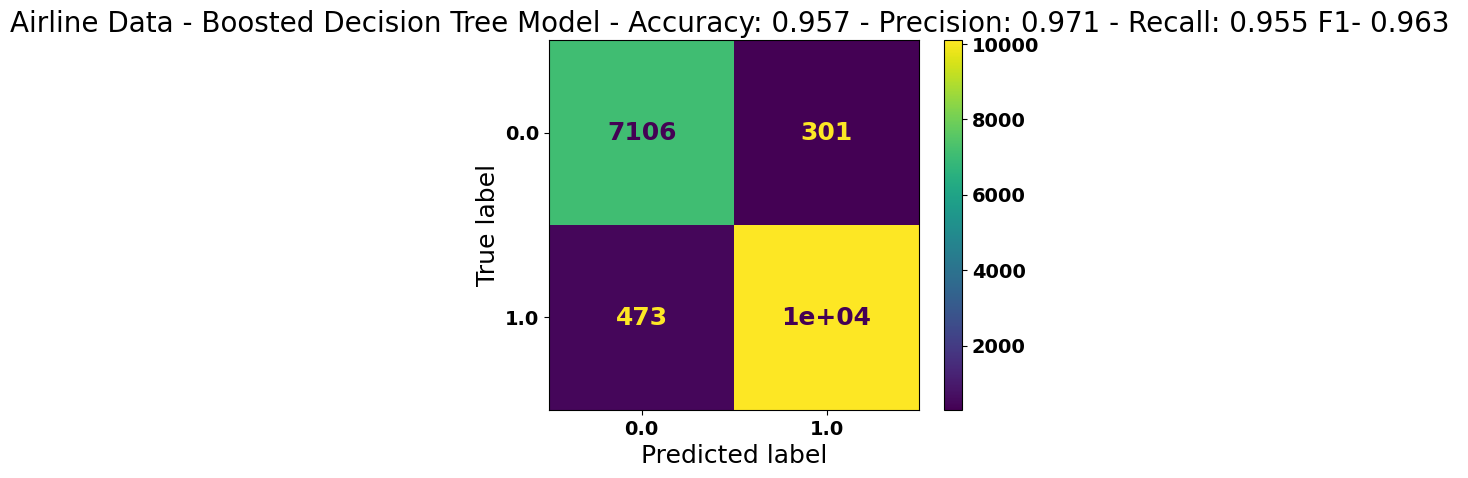

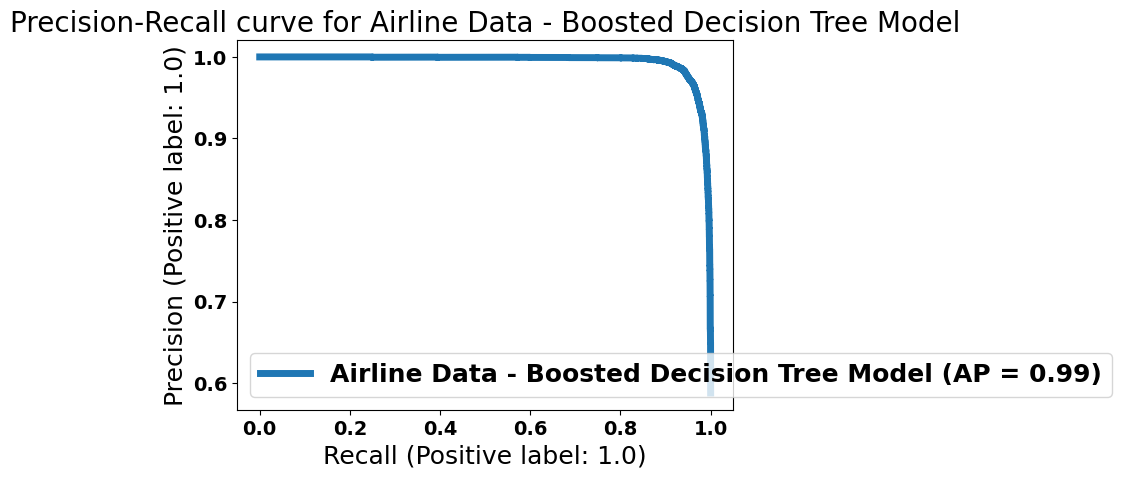

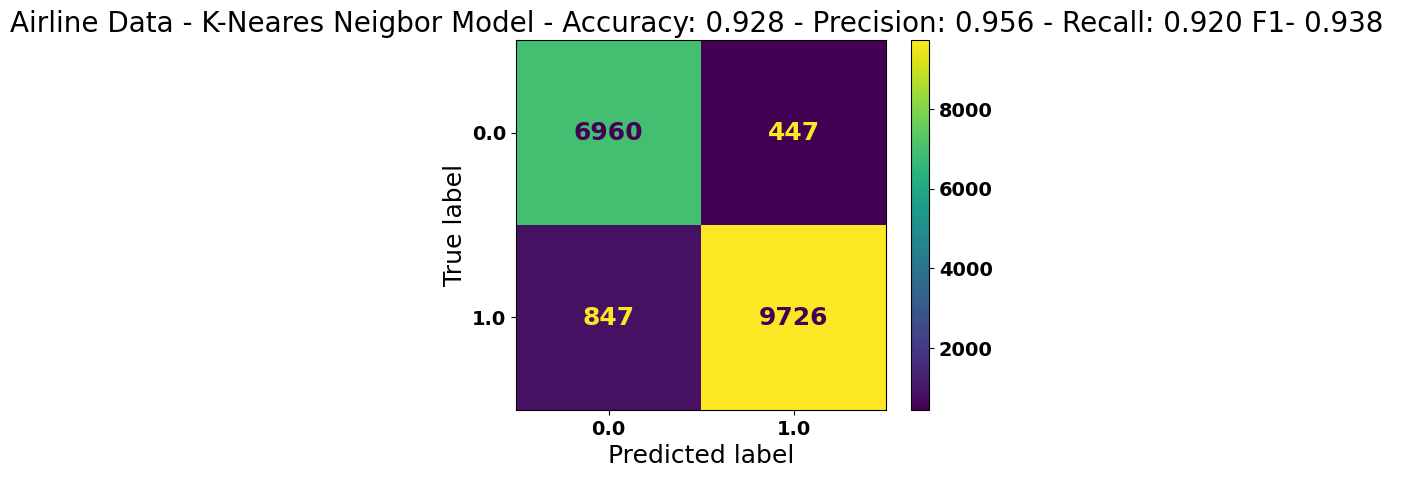

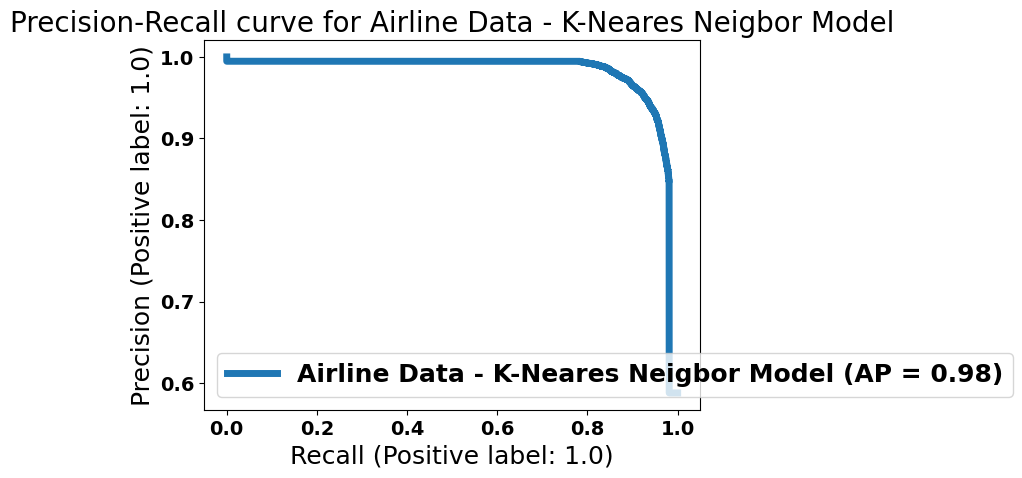

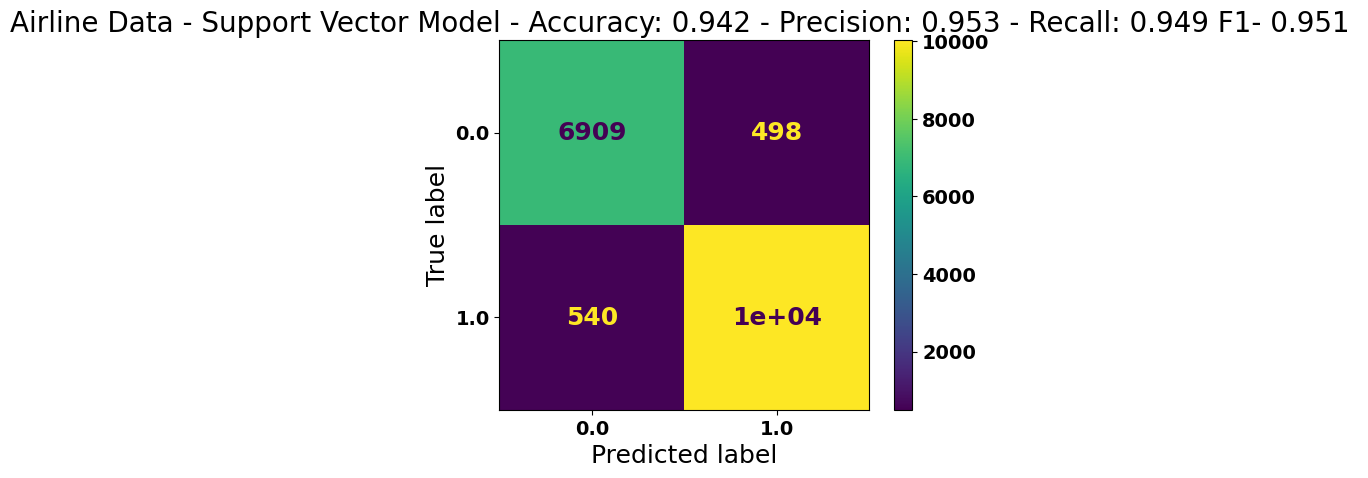

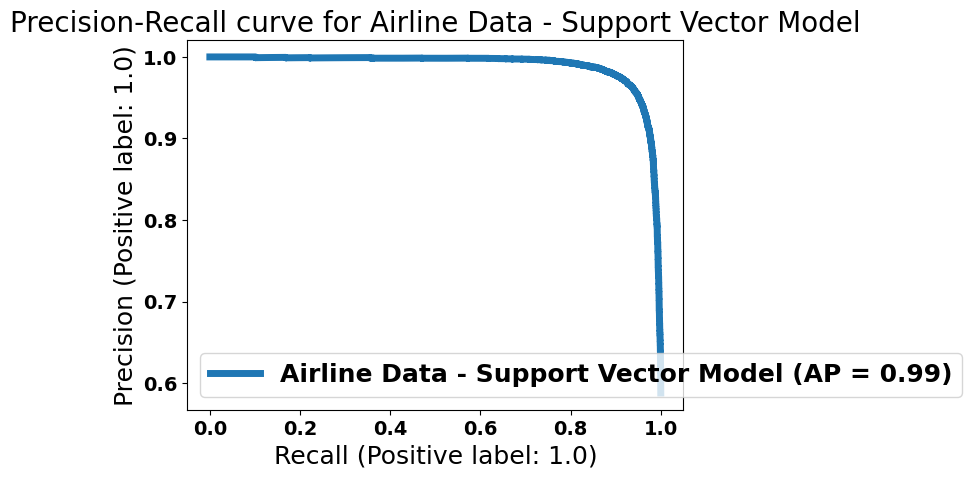

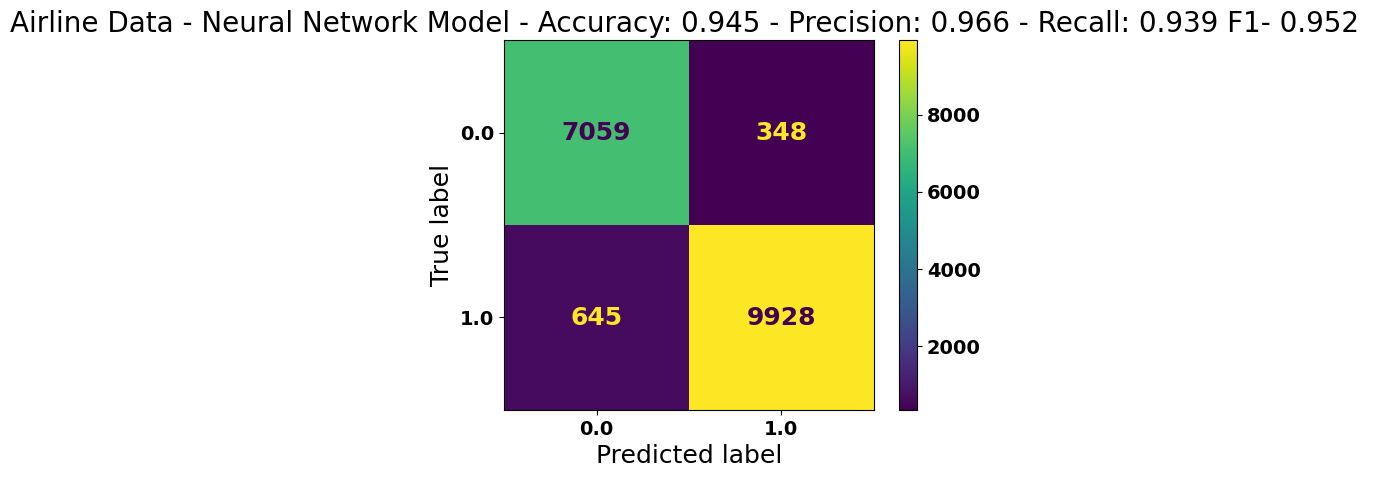

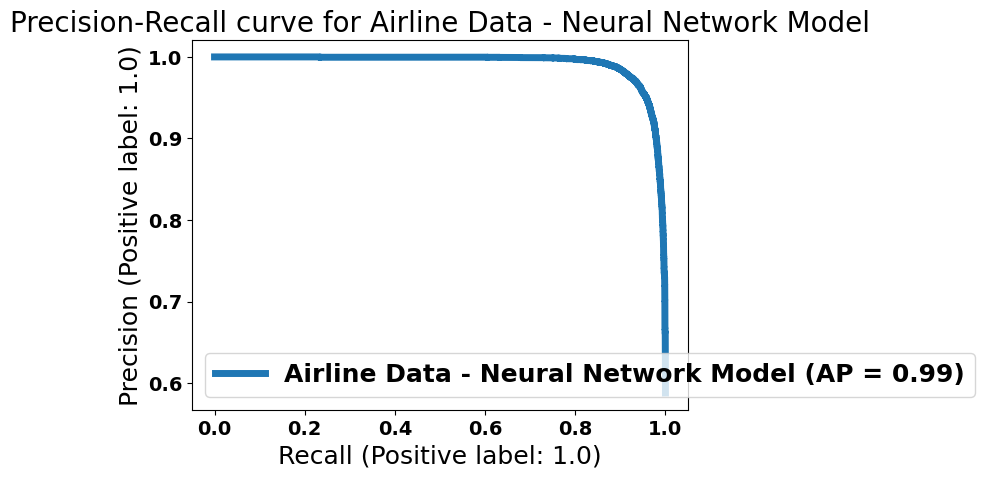

CPU times: user 24.9 s, sys: 10.3 s, total: 35.3 s
Wall time: 7.31 s


In [17]:
%%time
plot_confusion_matrices(classifiers_airline,X_airline,y_airline)

## Now Diabetes Dataset

In [18]:

diabetes_data =  pd.read_csv('./diabetes_test_data.csv',index_col=0)



In [19]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50736 entries, 245583 to 174432
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                50736 non-null  float64
 1   HighChol              50736 non-null  float64
 2   CholCheck             50736 non-null  float64
 3   BMI                   50736 non-null  float64
 4   Smoker                50736 non-null  float64
 5   Stroke                50736 non-null  float64
 6   HeartDiseaseorAttack  50736 non-null  float64
 7   PhysActivity          50736 non-null  float64
 8   Fruits                50736 non-null  float64
 9   Veggies               50736 non-null  float64
 10  HvyAlcoholConsump     50736 non-null  float64
 11  AnyHealthcare         50736 non-null  float64
 12  NoDocbcCost           50736 non-null  float64
 13  GenHlth               50736 non-null  float64
 14  MentHlth              50736 non-null  float64
 15  PhysHlth     

## Check for imbalanced dataset

In [20]:
## If forecasting diabetes, is the data imbalanced
diabetes_data['Diabetes_binary'].value_counts()

0.0    43641
1.0     7095
Name: Diabetes_binary, dtype: int64

In [21]:
diabetes_data.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Diabetes_binary'],
      dtype='object')

In [22]:
X_diabetes=diabetes_data

In [23]:
y_diabetes = X_diabetes['Diabetes_binary']
X_diabetes = X_diabetes[['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
                         'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
                         'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
                         'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']]

In [24]:
y_diabetes.value_counts()

0.0    43641
1.0     7095
Name: Diabetes_binary, dtype: int64

## Read diabetes models and produce test score

In [25]:
with open('best_search_decision_diabetes.pkl', 'rb') as f:
    best_search_decision_diabetes = pickle.load(f)
with open('best_search_boosted_diabetes.pkl', 'rb') as f:
    best_search_boosted_diabetes = pickle.load(f)
with open('best_search_knn_diabetes.pkl', 'rb') as f:
    best_search_knn_diabetes = pickle.load(f)
with open('best_search_svm_diabetes.pkl', 'rb') as f:
    best_search_svm_diabetes = pickle.load(f)
with open('best_search_nn_diabetes.pkl', 'rb') as f:
    best_search_nn_diabetes = pickle.load(f)

In [26]:
classifiers_diabetes = {
    'Diabetes Data - Decision Tree Model': best_search_decision_diabetes, 
    'Diabetes Data - Boosted Decision Tree Model':best_search_boosted_diabetes, 
    'Diabetes Data - K-Nearest Neigbor Model': best_search_knn_diabetes,
    'Diabetes Data - Support Vector Model': best_search_svm_diabetes,
    'Diabetes Data - Neural Network Model': best_search_nn_diabetes
}


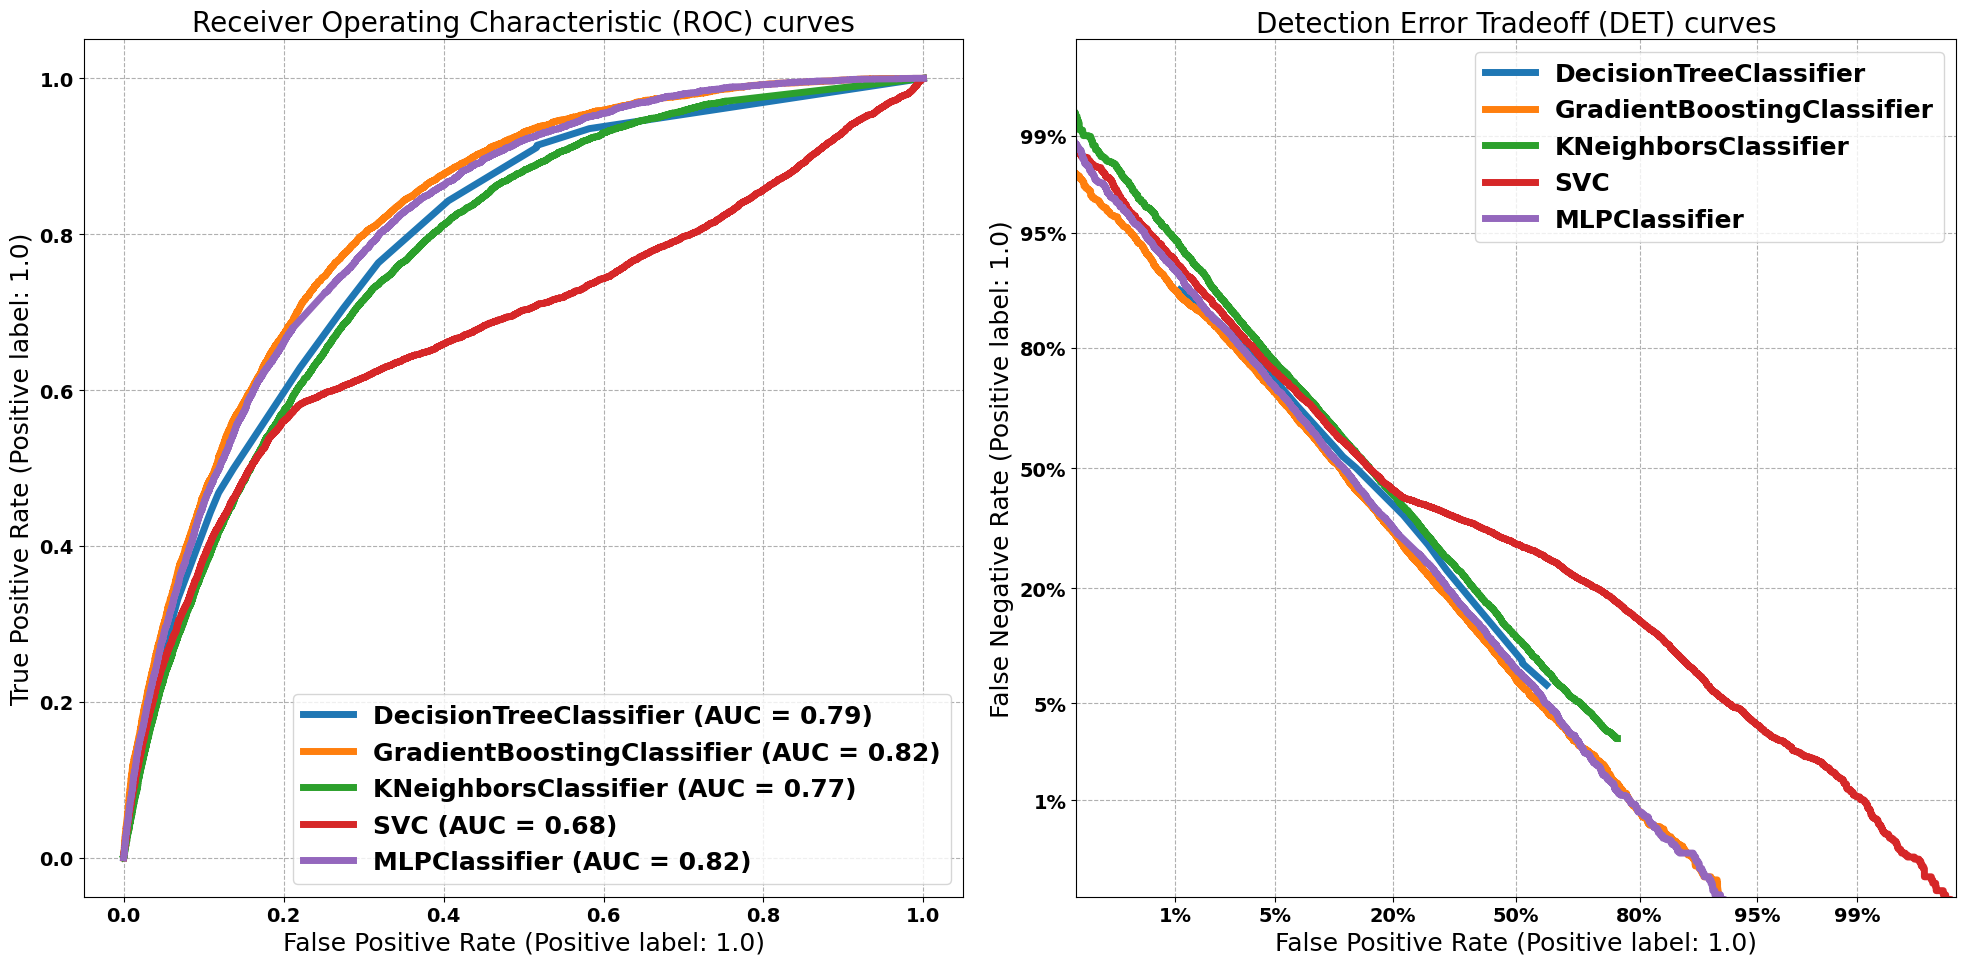

In [27]:
plot_roc_det_curves([best_search_decision_diabetes, best_search_boosted_diabetes, best_search_knn_diabetes,best_search_svm_diabetes,best_search_nn_diabetes],
                    X_diabetes,y_diabetes,'diabetes_test_result_roc_det_curve.png')

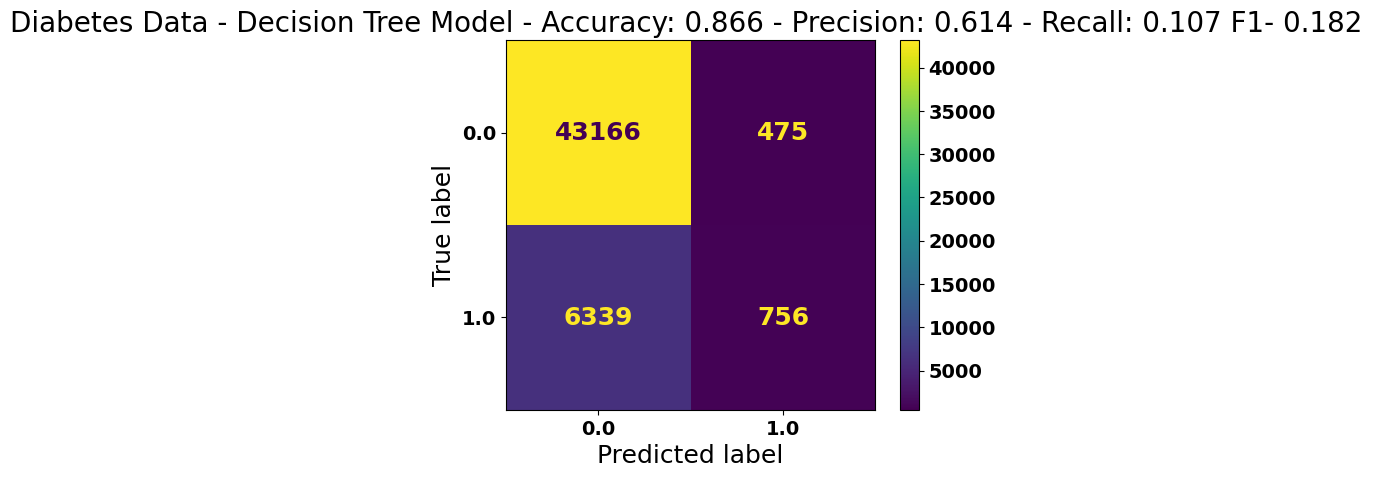

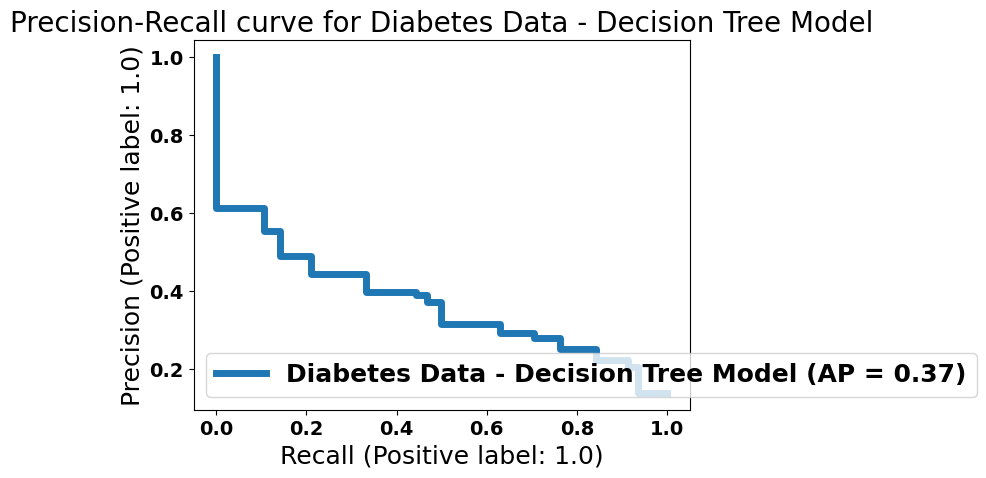

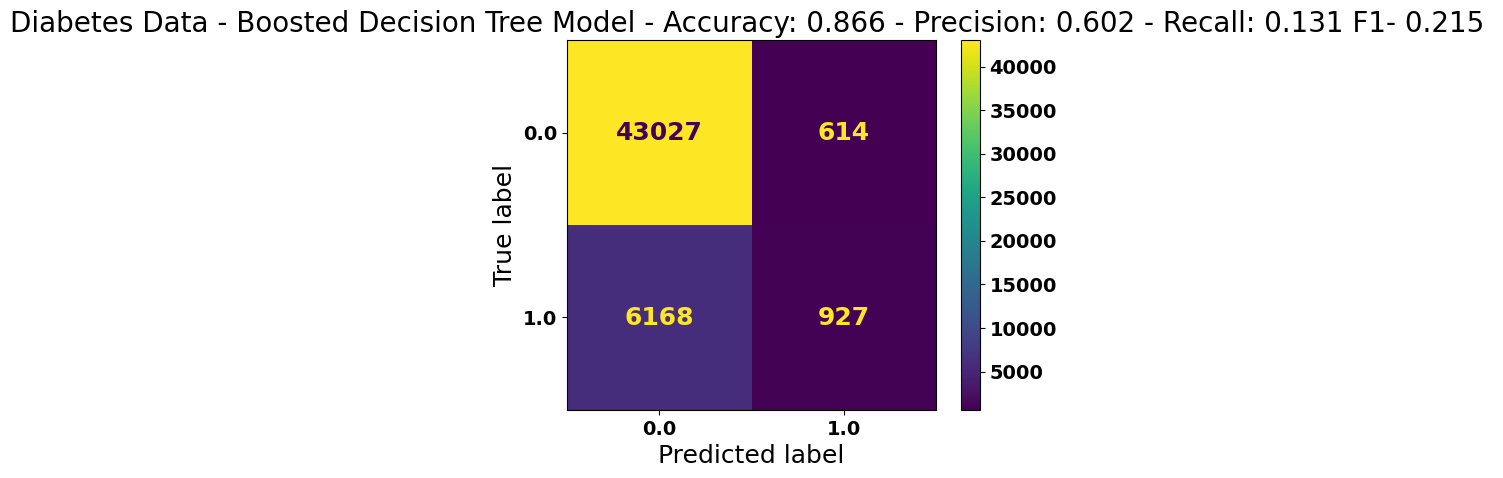

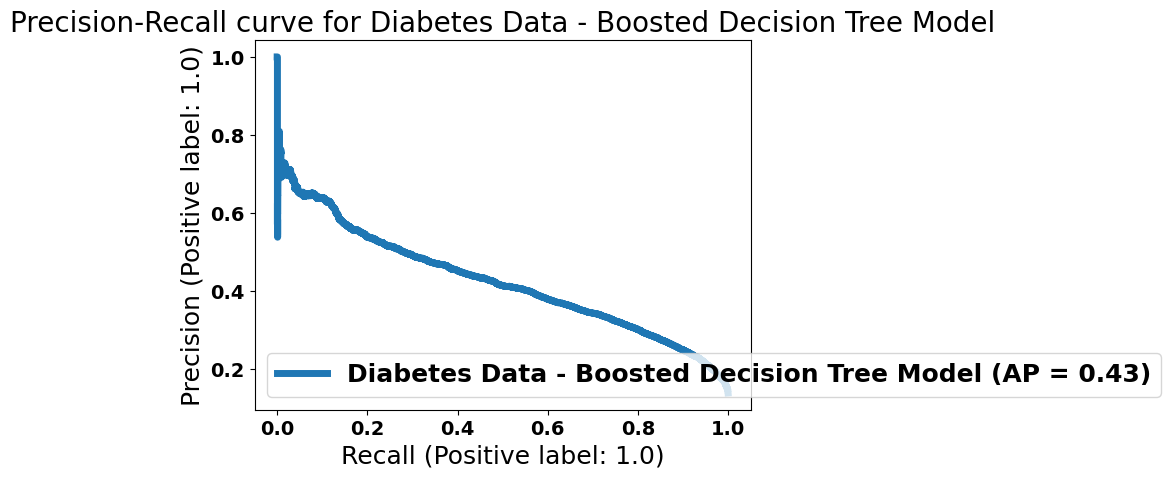

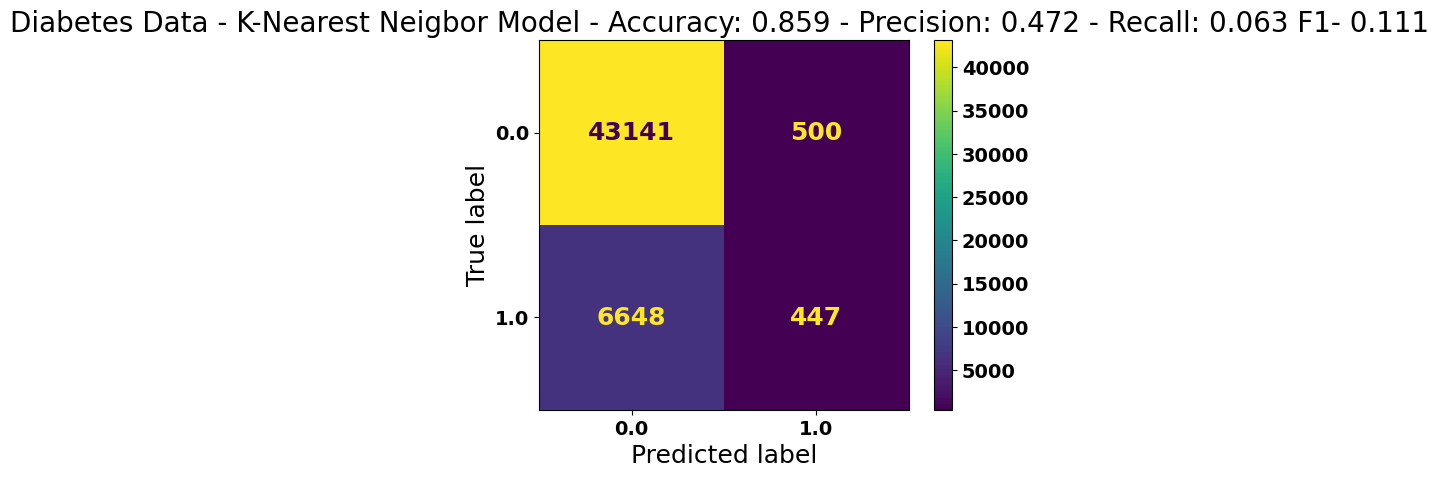

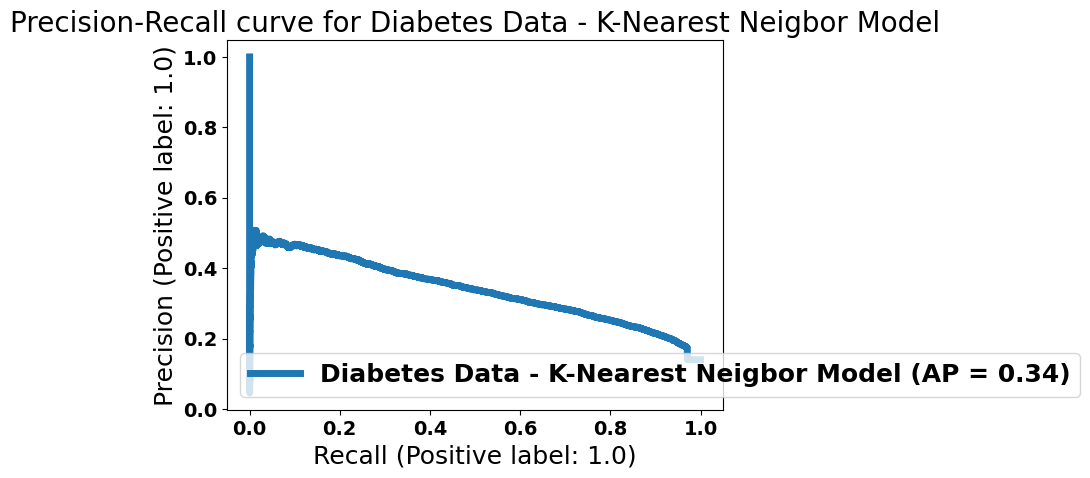

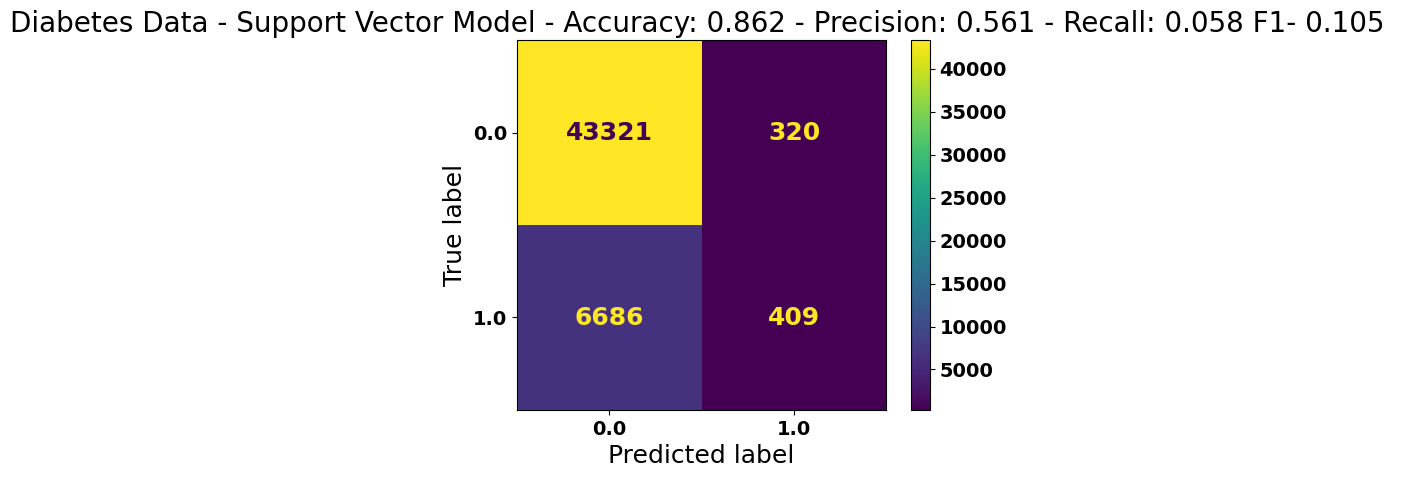

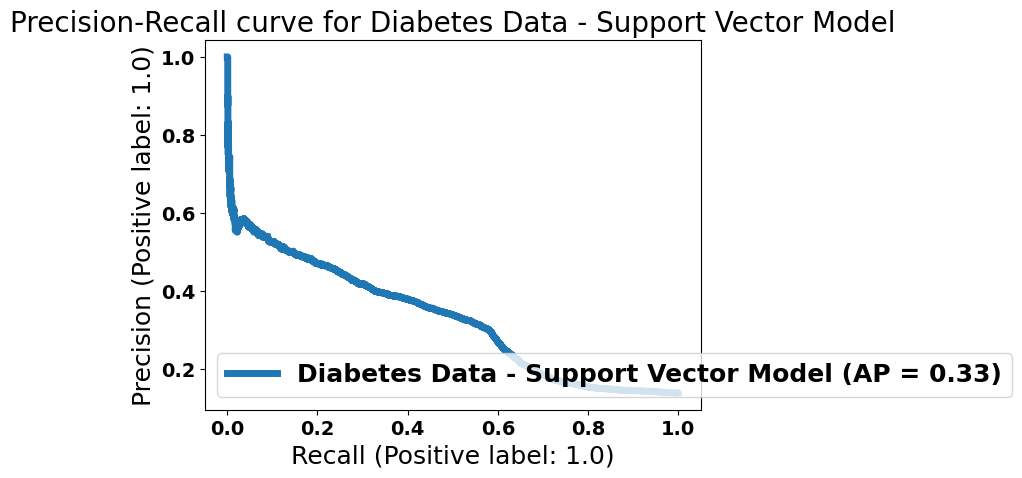

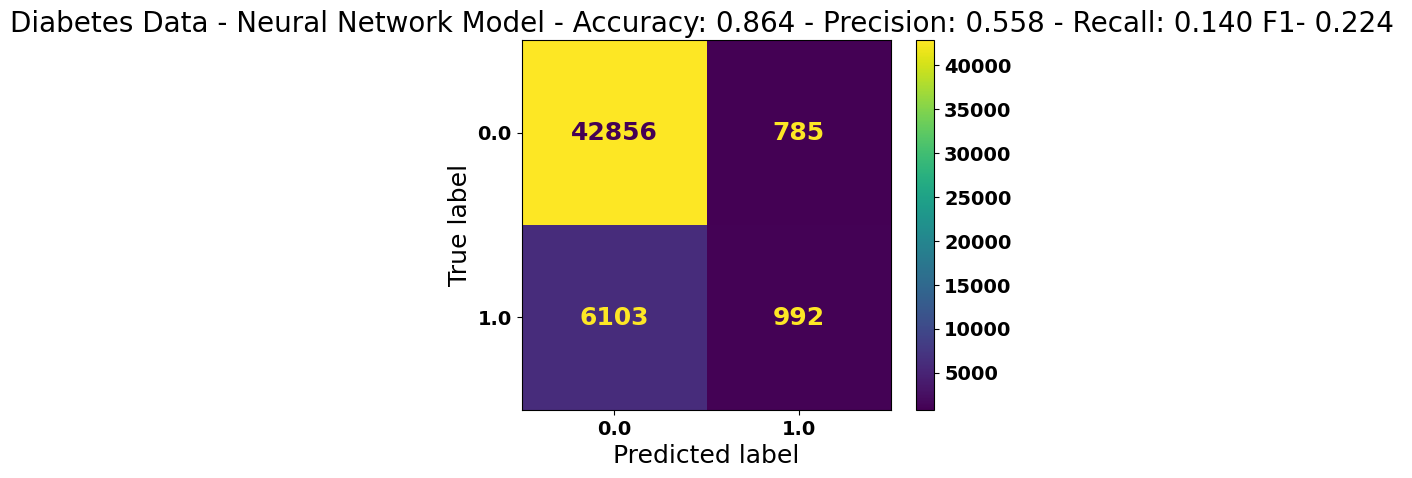

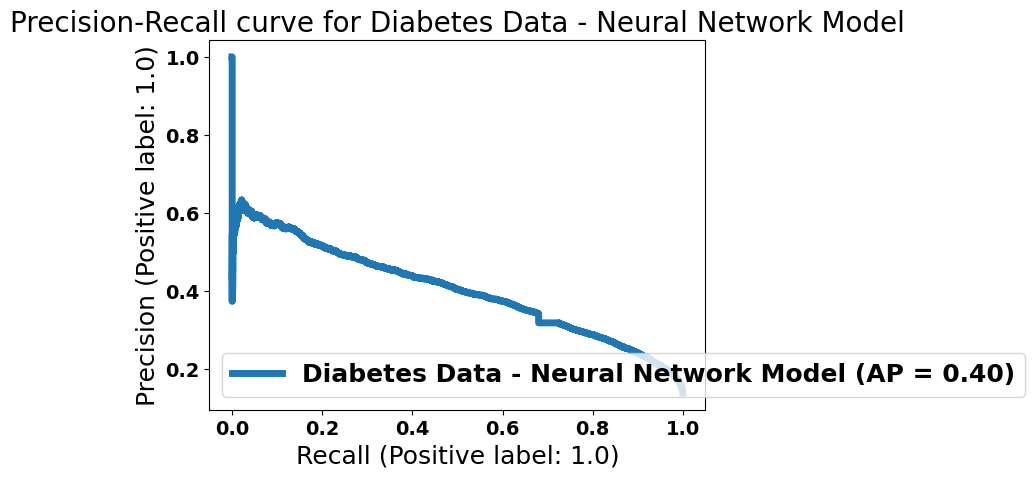

In [28]:
plot_confusion_matrices(classifiers_diabetes,X_diabetes,y_diabetes)